# Molecular dynamics simulations with OpenMM
[OpenMM](http://openmm.org/) is software library for performing molecular dynamics simulations. It is designed to be flexible and efficient and it focuses on simulations of biomolecules. OpenMM is written in C++ and CUDA and has Python bindings, which makes it easy to use in Python scripts. In this example, we will show how to set up molecular dynamics simulations using OpenMM.

In [24]:
import openmm as mm
import openmm.app as app
import openmm.unit as unit
import numpy as np
import matplotlib.pyplot as plt

## 1. A 1-D harmonic oscillator
We will start with a simple example of a 1-D harmonic oscillator. In the example, we have a particle of mass 1 amu that is connected to a fixed point by a spring. The particle is constrained to move along the x-axis. The spring has a force constant of 1 kJ/mol/nm^2. The equilibrium position of the particle is at (0, 0, 0), which means the force is zero when the particle is at the origin.

OpenMM uses a class called `System` to represent the system that we want to simulate. The `System` class contains a list of particles and a list of forces acting on those particles. To simulate the 1-D harmonic oscillator described above, we need to create a `System` object for it.

In [25]:
## initialize an empty system
system = mm.System()

## dd two particles to the system, the first one will be fixed and the second one
## will be free to move in the x axis. The two particles will be connected by a spring

## add the first particle with mass 0 amu
## OpenMM has a special setting that massless particles are fixed
system.addParticle(0 * unit.amu) 

## add the second particle with mass 1 amu
system.addParticle(1.0 * unit.amu)

1

To model the spring between the two particles, we will add a force between the two particles. The force is given by Hooke's law: $f = -kx$, where $k$ is the force constant and $x$ is the displacement from the equilibrium position. The potential energy corresponding to this force is given by $V = \frac{1}{2}kx^2$, which is called the harmonic potential. As a rule of thumb, it is usually easier to specify the potential energy function rather than the force function.

OpenMM has a built-in class called `HarmonicBondForce` for harmonic potentials.

In [26]:
## initialize a HarmonicBondForce
harmonic_force = mm.HarmonicBondForce()

## specify that the force is between the particles with index 0 and 1.
## the index of a particle is the order in which it was added to the system and starts at 0
harmonic_force.addBond(0, 1, 0.0 * unit.angstrom, 1. * unit.kilojoule_per_mole / unit.angstrom**2)

## add the force to the system
system.addForce(harmonic_force)

0

In [27]:
k_external = 100
external_force = mm.CustomExternalForce('0.5*k_external*(y^2 + z^2)')
external_force.addGlobalParameter('k_external', k_external)
external_force.addParticle(1, [])

system.addForce(external_force)

1

In [ ]:
integrator = mm.VerletIntegrator(stepSize=0.3 * unit.picosecond)
platform = mm.Platform.getPlatformByName("Reference")
context = mm.Context(system, integrator, platform)

## set the initial positions of the particles
init_x = np.array(
    [
        [0.0, 0.0, 0.0],  # particle 0
        [1.0, 0.0, 0.0],  # particle 1
    ]
)

context.setPositions(init_x)




Run a simulation of the system. We use a Langevin integrator to simulate the system at a constant temperature of 300 K. Using OpenMM, we can choose to run simulations on different platforms that support different hardware. Here we use the Reference platform, which is the slowest one and is useful for testing and debugging. The CPU platform should be used for running production simulations on a CPU. The CUDA platform uses NVIDIA GPUs and is the fastest one. It should be used for running production simulations on a GPU. Here our system is too small to benefit from GPU acceleration, so we use the Reference platform.

In [22]:
integrator = mm.LangevinMiddleIntegrator(300 * unit.kelvin, 1.0 / unit.picosecond, 0.002 * unit.picosecond)

## request the Reference platform
platform = mm.Platform.getPlatformByName('Reference')

## create a simulation context
context = mm.Context(system, integrator, platform)

## set the initial positions of the particles
positions = np.array([[0.0, 0.0, 0.0], [1.0, 0.0, 0.0]], np.float32) * unit.angstrom
context.setPositions(positions)

Running the simulation involves repeatedly calling the step() method of the integrator. This advances the simulation by a specified number of time steps. As the simulation runs, we can query the state of the system to get information about it. For example, here we record the positions and potential energy of the system every 1000 steps.

In [23]:
## run the simulation
xyz = []
us = []
for i in range(3000):
    ## run 1000 steps of dynamics
    integrator.step(1000)

    ## get the positions and potential energy of the system and record them
    state = context.getState(getEnergy=True, getPositions=True)
    xyz.append(state.getPositions(asNumpy=True).value_in_unit(unit.angstrom))
    u = state.getPotentialEnergy().value_in_unit(unit.kilojoule_per_mole)
    us.append(u)
    if (i + 1) % 100 == 0:
        print(i, f'{u:.3f} kJ/mol')

99 3.314 kJ/mol
199 1.258 kJ/mol
299 7.066 kJ/mol
399 1.335 kJ/mol
499 1.128 kJ/mol
599 5.104 kJ/mol
699 0.614 kJ/mol
799 1.375 kJ/mol
899 0.966 kJ/mol
999 1.010 kJ/mol
1099 0.585 kJ/mol
1199 1.013 kJ/mol
1299 0.495 kJ/mol
1399 1.245 kJ/mol
1499 2.760 kJ/mol
1599 0.758 kJ/mol
1699 1.128 kJ/mol
1799 2.066 kJ/mol
1899 3.559 kJ/mol
1999 1.161 kJ/mol
2099 3.399 kJ/mol
2199 5.848 kJ/mol
2299 2.791 kJ/mol
2399 2.857 kJ/mol
2499 2.127 kJ/mol
2599 1.957 kJ/mol
2699 3.724 kJ/mol
2799 1.057 kJ/mol
2899 1.768 kJ/mol
2999 0.873 kJ/mol


Now that the simulation is complete, let us analyze the trajectory. We will calculate the distance between the two particles and plot a histogram of the distances and the time series of the distance.

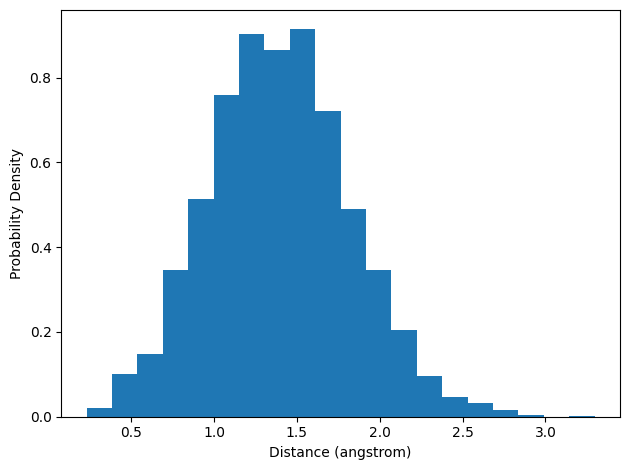

In [9]:
## Now let's analyze the trajectory
xyz = np.array(xyz)

d = np.linalg.norm(xyz[:, 1, :] - xyz[:, 0, :], axis=1)

fig = plt.figure()
plt.clf()
plt.hist(d, bins=20, density=True)
plt.xlabel('Distance (angstrom)')
plt.ylabel('Probability Density')
plt.tight_layout()

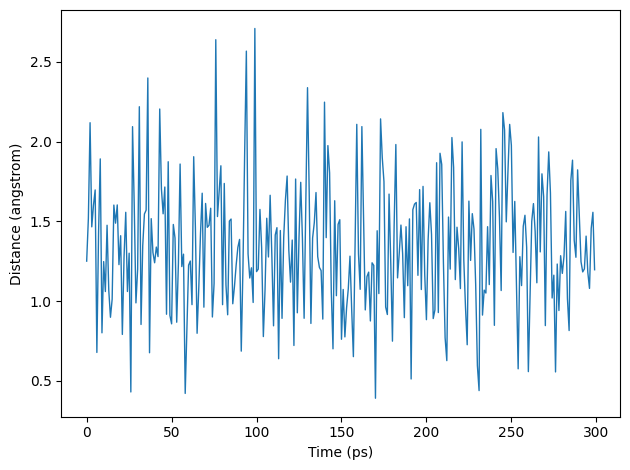

In [11]:
fig = plt.figure()
plt.clf()
plt.plot(d[::10], linewidth=1)
plt.xlabel('Time (ps)')
plt.ylabel('Distance (angstrom)')
plt.tight_layout()


We see that the distance between the two particles fluctuates randomly during the simulation. However, the distribution of distances converges to the equilibrium distribution predicted by the Boltzmann distribution. You could notice that the mean of the distance is not 1 angstrom, which is the equilibrium distance of the harmonic bond. You should think about why this is the case.